In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms
import seaborn as sns


In [166]:
class momentumBackTester():
    def __init__(self, asset_name, start, end, transaction_cost = 0, price_col = 'Adj Close'):
        self.asset_name = asset_name
        self.start = start
        self.end = end
        self.price_col = price_col
        self.data = self.data_processor(pd.read_csv(self.asset_name+'.csv', index_col = 0, parse_dates = True).dropna())
        #self.data= yf.download(asset_name, start=start)
        self.marketReturn = self.data.tail(1).values[0] / self.data.head(1).values[0]
        
        # return initialization
        self.data['returns'] = np.log(self.data['price']/self.data['price'].shift(1))              # if p[T + 1] > p[T], return for T > 0
        
    def data_processor(self,raw):
        price_col = self.price_col
        data = pd.DataFrame(raw[price_col])
        data.rename(columns = {price_col: 'price'}, inplace = True)
        
        # date mask
        mask = (data.index > self.start) & (data.index <= self.end)
        data = data.loc[mask]
        return data
    
    def single_test(self,window,plot = True):
        data = self.data
        rollingWindow = window

        data['position'] = np.sign(data['returns'].rolling(rollingWindow).mean())   # if mean of return during rolling window > 0, 
                                                                                    # position has positive sign ( = 1.0)

        data['strat'] = data['position'].shift(1) * data['returns']                 # strat = sign * return 
        
        df = data[['returns', 'strat']].dropna().cumsum().apply(np.exp)
        return_strategy = df.tail(1).values[0][1]
        print("Return for strategy (window = %d): %s" %(window, format(return_strategy* 100 - 100, ".2f")) +"%")
        
        if plot:
            df.plot(title = self.asset_name + ' Return and Strategy Return, rolling window = ' + str(window), figsize=(10, 6))
        
    def multiple_test(self, min, max, step,plot = True):
        data = self.data
        plot_col = ['returns']

        strat_cnt = 0
        line_style = ['-']
        for w in range(min,max,step):
            data['position_%d' % w] = np.sign(data['returns'].rolling(w).mean())   
            data['strat_%d' % w] = data['position_%d' % w].shift(1) * data['returns']                 # strat = sign * return          
            plot_col.append('strat_%d' % w)
            strat_cnt += 1
            line_style.append('--')
        
        df = data[plot_col].dropna().cumsum().apply(np.exp)
        
        #print function
        for w in range(min,max,step):
            return_strategy = df['strat_%d' % w].tail(1).values[0]
            print("Return for strategy (window = %d): %s" %(w,format(return_strategy* 100 - 100, ".2f") ) + "%")
            
        if plot:
            df.plot(title = 'TSLA Return and Strategies Comparison', 
                                                                        figsize=(16, 9), style = line_style)
        
        
    def getSharpeRatio(self):
        data = self.data
        std=  data['returns'].std()
        

    def drawHeatMap(self, windowMax, windowMin = 1):
        data = self.data      
        plot_col = ['returns']
        new_columns_position = {}
        new_columns_strat = {}
        for w in range(windowMin,windowMax):
            new_columns_position['position_%d' %w] =  np.sign(data['returns'].rolling(w).mean())   
        
        new_columns_position= pd.DataFrame(new_columns_position, index = data.index)
        data = pd.concat([data,new_columns_position],axis = 1)
   
        for w in range(windowMin,windowMax):
            new_columns_strat['strat_%d' % w] = data['position_%d' % w].shift(1) * data['returns']                 # strat = sign * return          
            plot_col.append('strat_%d' % w)
        
        new_columns_strat = pd.DataFrame(new_columns_strat, index = data.index)
        data = pd.concat([data,new_columns_strat],axis = 1)
        
        df = data[plot_col].dropna().cumsum().apply(np.exp)
        df2 = data[plot_col].dropna()
        
        returns = []
        std = []
        returns_daily_mean = []
        
        
        for w in range(windowMin,windowMax):
            returns.append(df['strat_%d' % w].tail(1).values[0] - 1)
            # for Sharpe Ratio
            std.append(df2['strat_%d' % w].std())
            returns_daily_mean.append(df2['strat_%d' % w].mean())
        
        # plot HEATMAP
        plt.figure(dpi = 1200)
        dt = {'Return %':returns}
        df_hm =pd.DataFrame(dt).sort_values('Return %', ascending=False)
        df_hm.index = df_hm.index + 1
        df_hm *= 100 # PERCENTAGE
        ax = sns.heatmap(df_hm).set_title("return% on "+ self.asset_name + " at windows lengths ")
        print("IMPORTANT NOTE: The start date in heatmap is the <startdate> + max window length which the strategy needs to decide position. \nIn other words, the start date is <start date> + ,for example, 200 trading days.")
        plt.savefig('returnsVSwindows.pdf')
        plt.show()
        
        # print TOP and BOTTOM returns
        head = df_hm.head(10)
        tail = df_hm.tail(10)
        
        print("Top 10 return \nWindow        Return")
        for index in head.index:
            ret = "{0:.2f}".format(head['Return %'][index])
            print("{0:>6}     {1:>9}".format(str(index), ret))
        
        print("Bottom 10 return:\nWindow        Return")
        for index in tail.index:
            ret = "{0:.2f}".format(tail['Return %'][index])
            print("{0:>6}     {1:>9}".format(str(index), ret))

         
        #SHARPE RATIO 
        SR = []
        for i in range(0,len(std)):
            SR.append((returns_daily_mean[i] / std[i])*(252**0.5) )
            
        plt.figure(dpi=1200)
        dt_sr = {'Sharpe Ratio' : SR}
        
        df_hm_sr =pd.DataFrame(dt_sr).sort_values('Sharpe Ratio', ascending = False)
        df_hm_sr.index = df_hm_sr.index + 1
        
        ax = sns.heatmap(df_hm_sr).set_title("Annualized Sharpe Ratio on "+ self.asset_name + " at windows lengths")
        plt.savefig('SRVSwindows.pdf')
        plt.show()
        
        
        head = df_hm_sr.head(10)
        tail = df_hm_sr.tail(10)
        
        print("Top 10 Sharpe Ratio \nWindow        Sharpe Ratio")
        for index in head.index:
            ret = "{0:.2f}".format(head['Sharpe Ratio'][index])
            print("{0:>6}     {1:>9}".format(str(index), ret))
        
        print("Bottom 10 Sharpe Ratio:\nWindow        Sharpe Ratio")
        for index in tail.index:
            ret = "{0:.2f}".format(tail['Sharpe Ratio'][index])
            print("{0:>6}     {1:>9}".format(str(index), ret))

         
        '''
        vec = np.asarray(returns)
        fig, ax = plt.subplots()
        tr = transforms.Affine2D().rotate_deg(90)
        vec2 = vec.reshape(vec.shape[0], 1)
        sns.heatmap(vec2,annot=True, fmt="f",xticklabels=False,yticklabels = step)
        plt.show(tr)
        '''
        

In [167]:
# initialization: input parameter: name(.csv), startDate, endDate.
engine = momentumBackTester('TSLA', '6/15/2017' , '6/15/2022')

IMPORTANT NOTE: The start date in heatmap is the <startdate> + max window length which the strategy needs to decide position. 
In other words, the start date is <start date> + ,for example, 200 trading days.


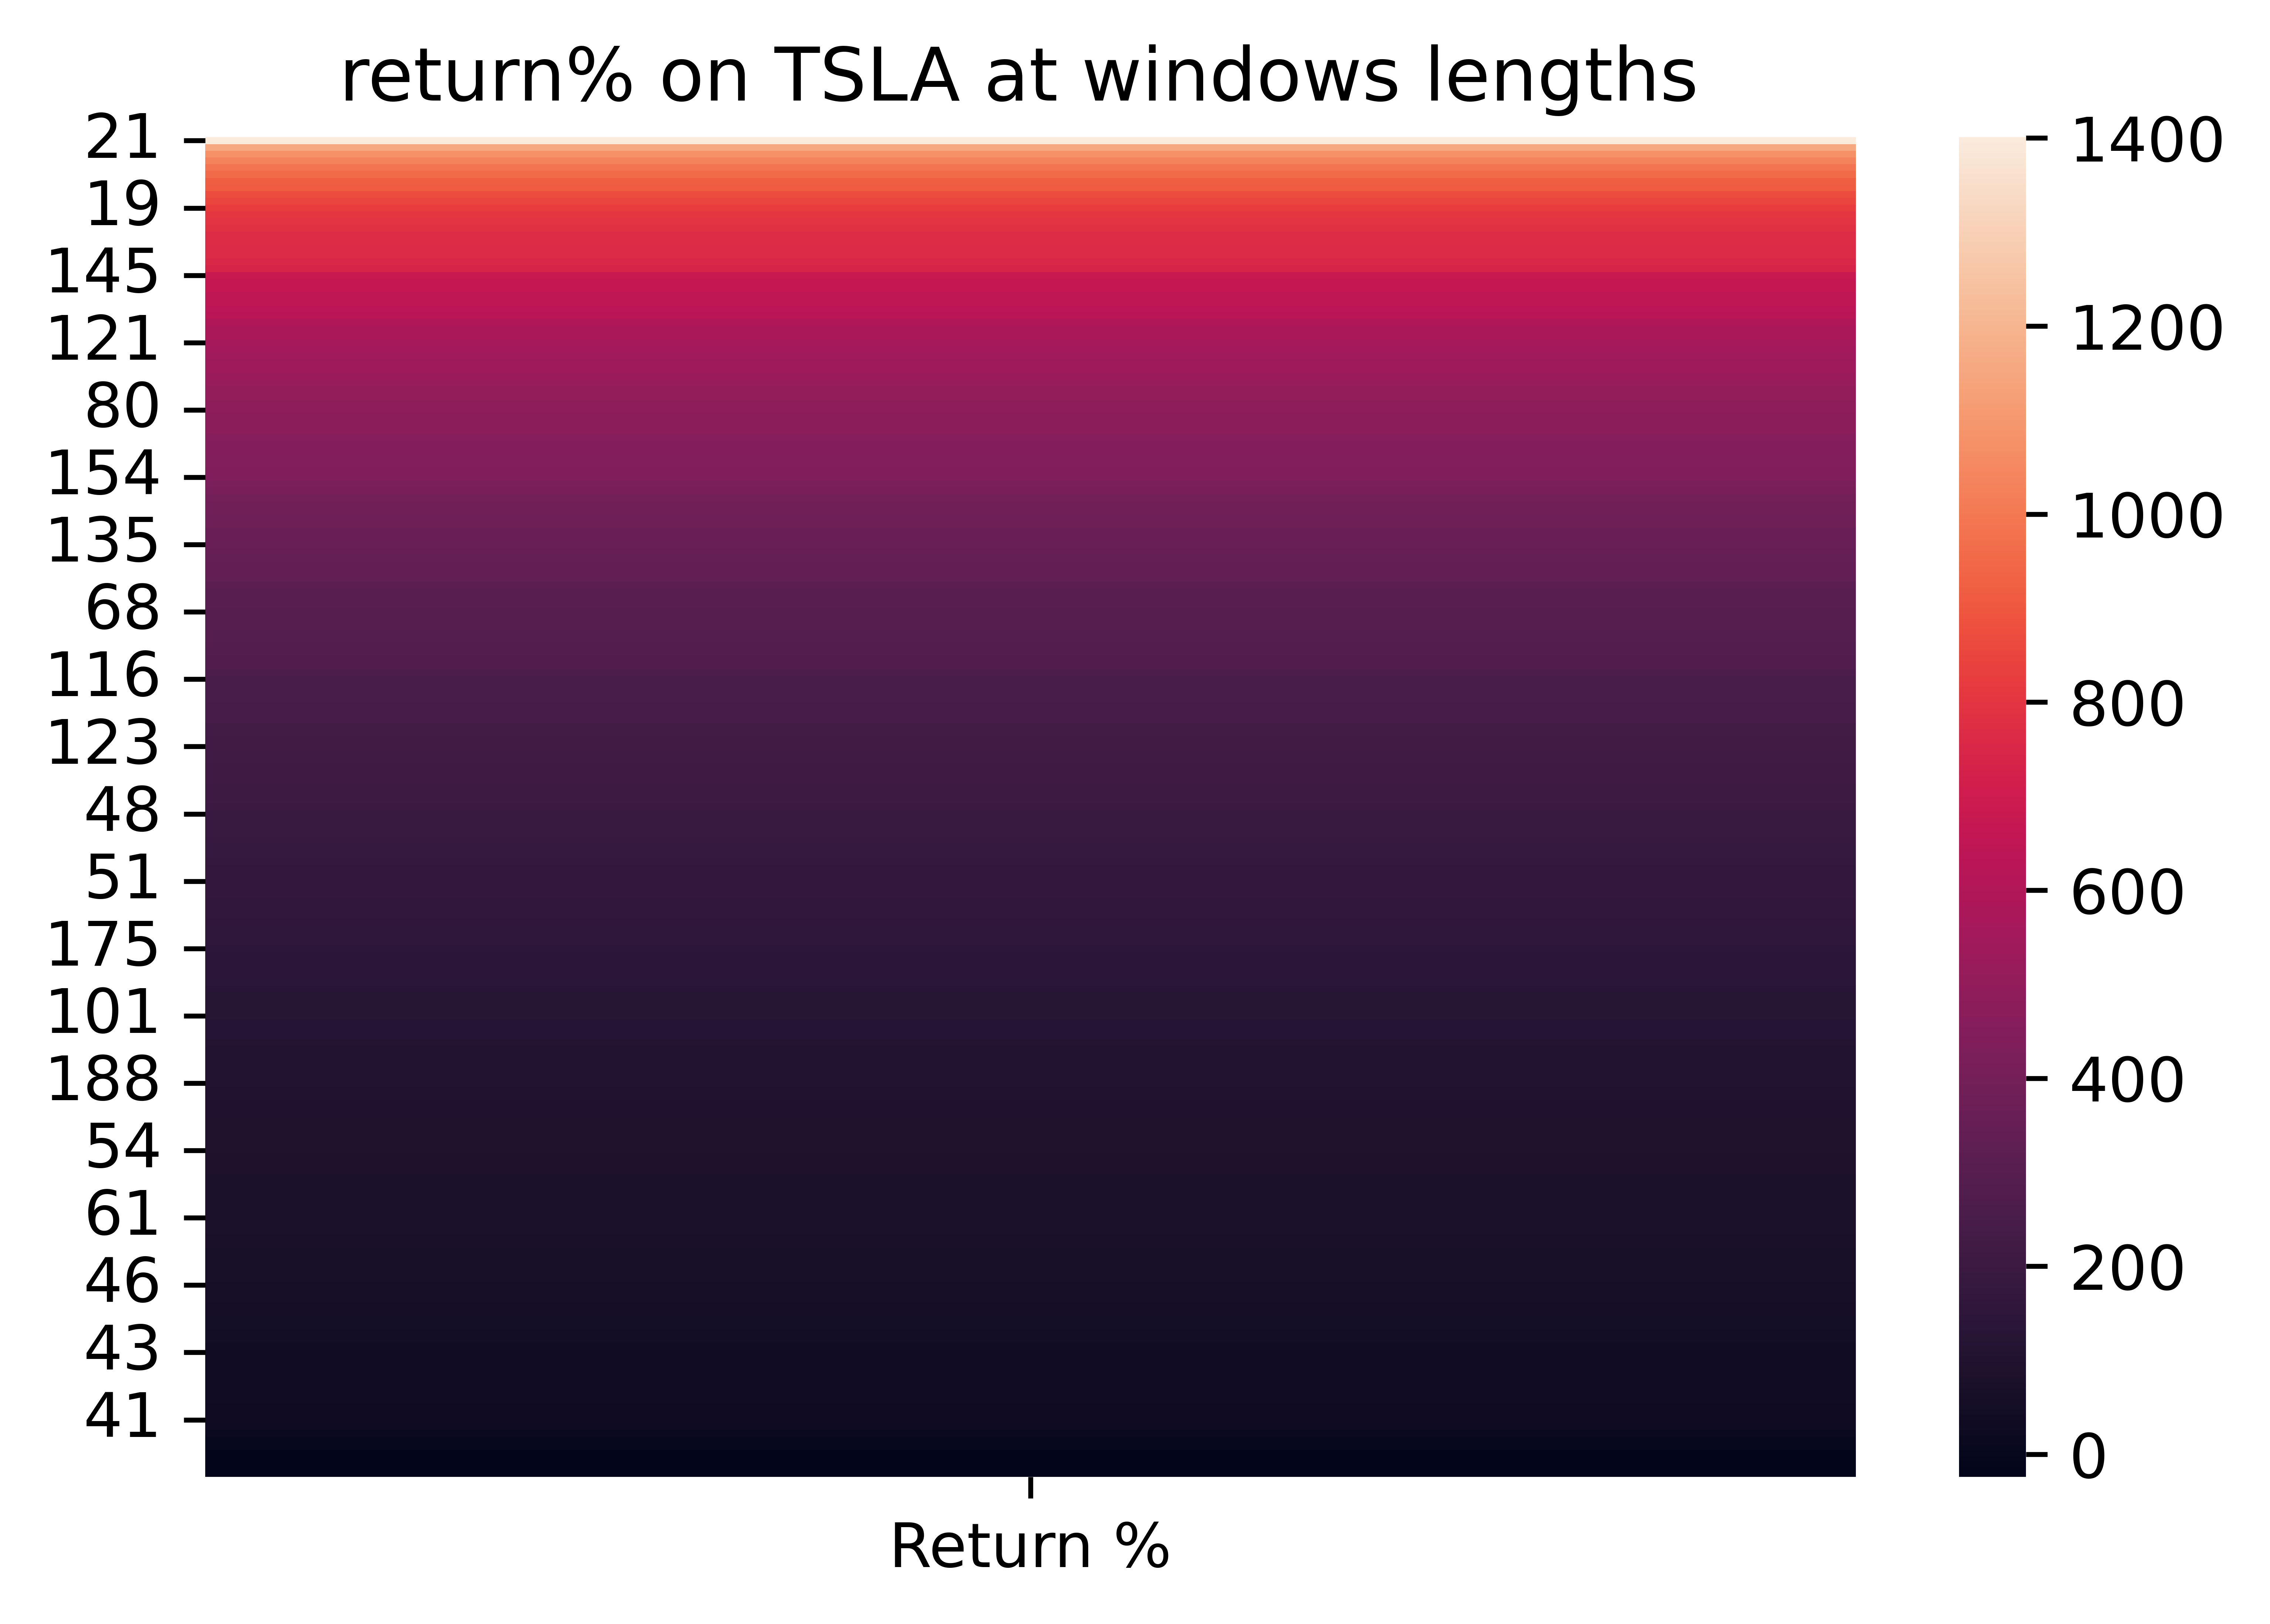

Top 10 return 
Window        Return
    21       1400.73
   126       1150.94
   125       1075.52
    78       1028.10
    77        986.66
    22        959.86
    18        916.71
    76        914.24
    72        866.68
   146        854.43
Bottom 10 return:
Window        Return
   184         34.06
    41         31.98
   199         29.04
    93         11.33
    37         -0.91
    92         -1.08
    57        -18.83
    58        -19.37
    56        -20.65
    44        -24.16


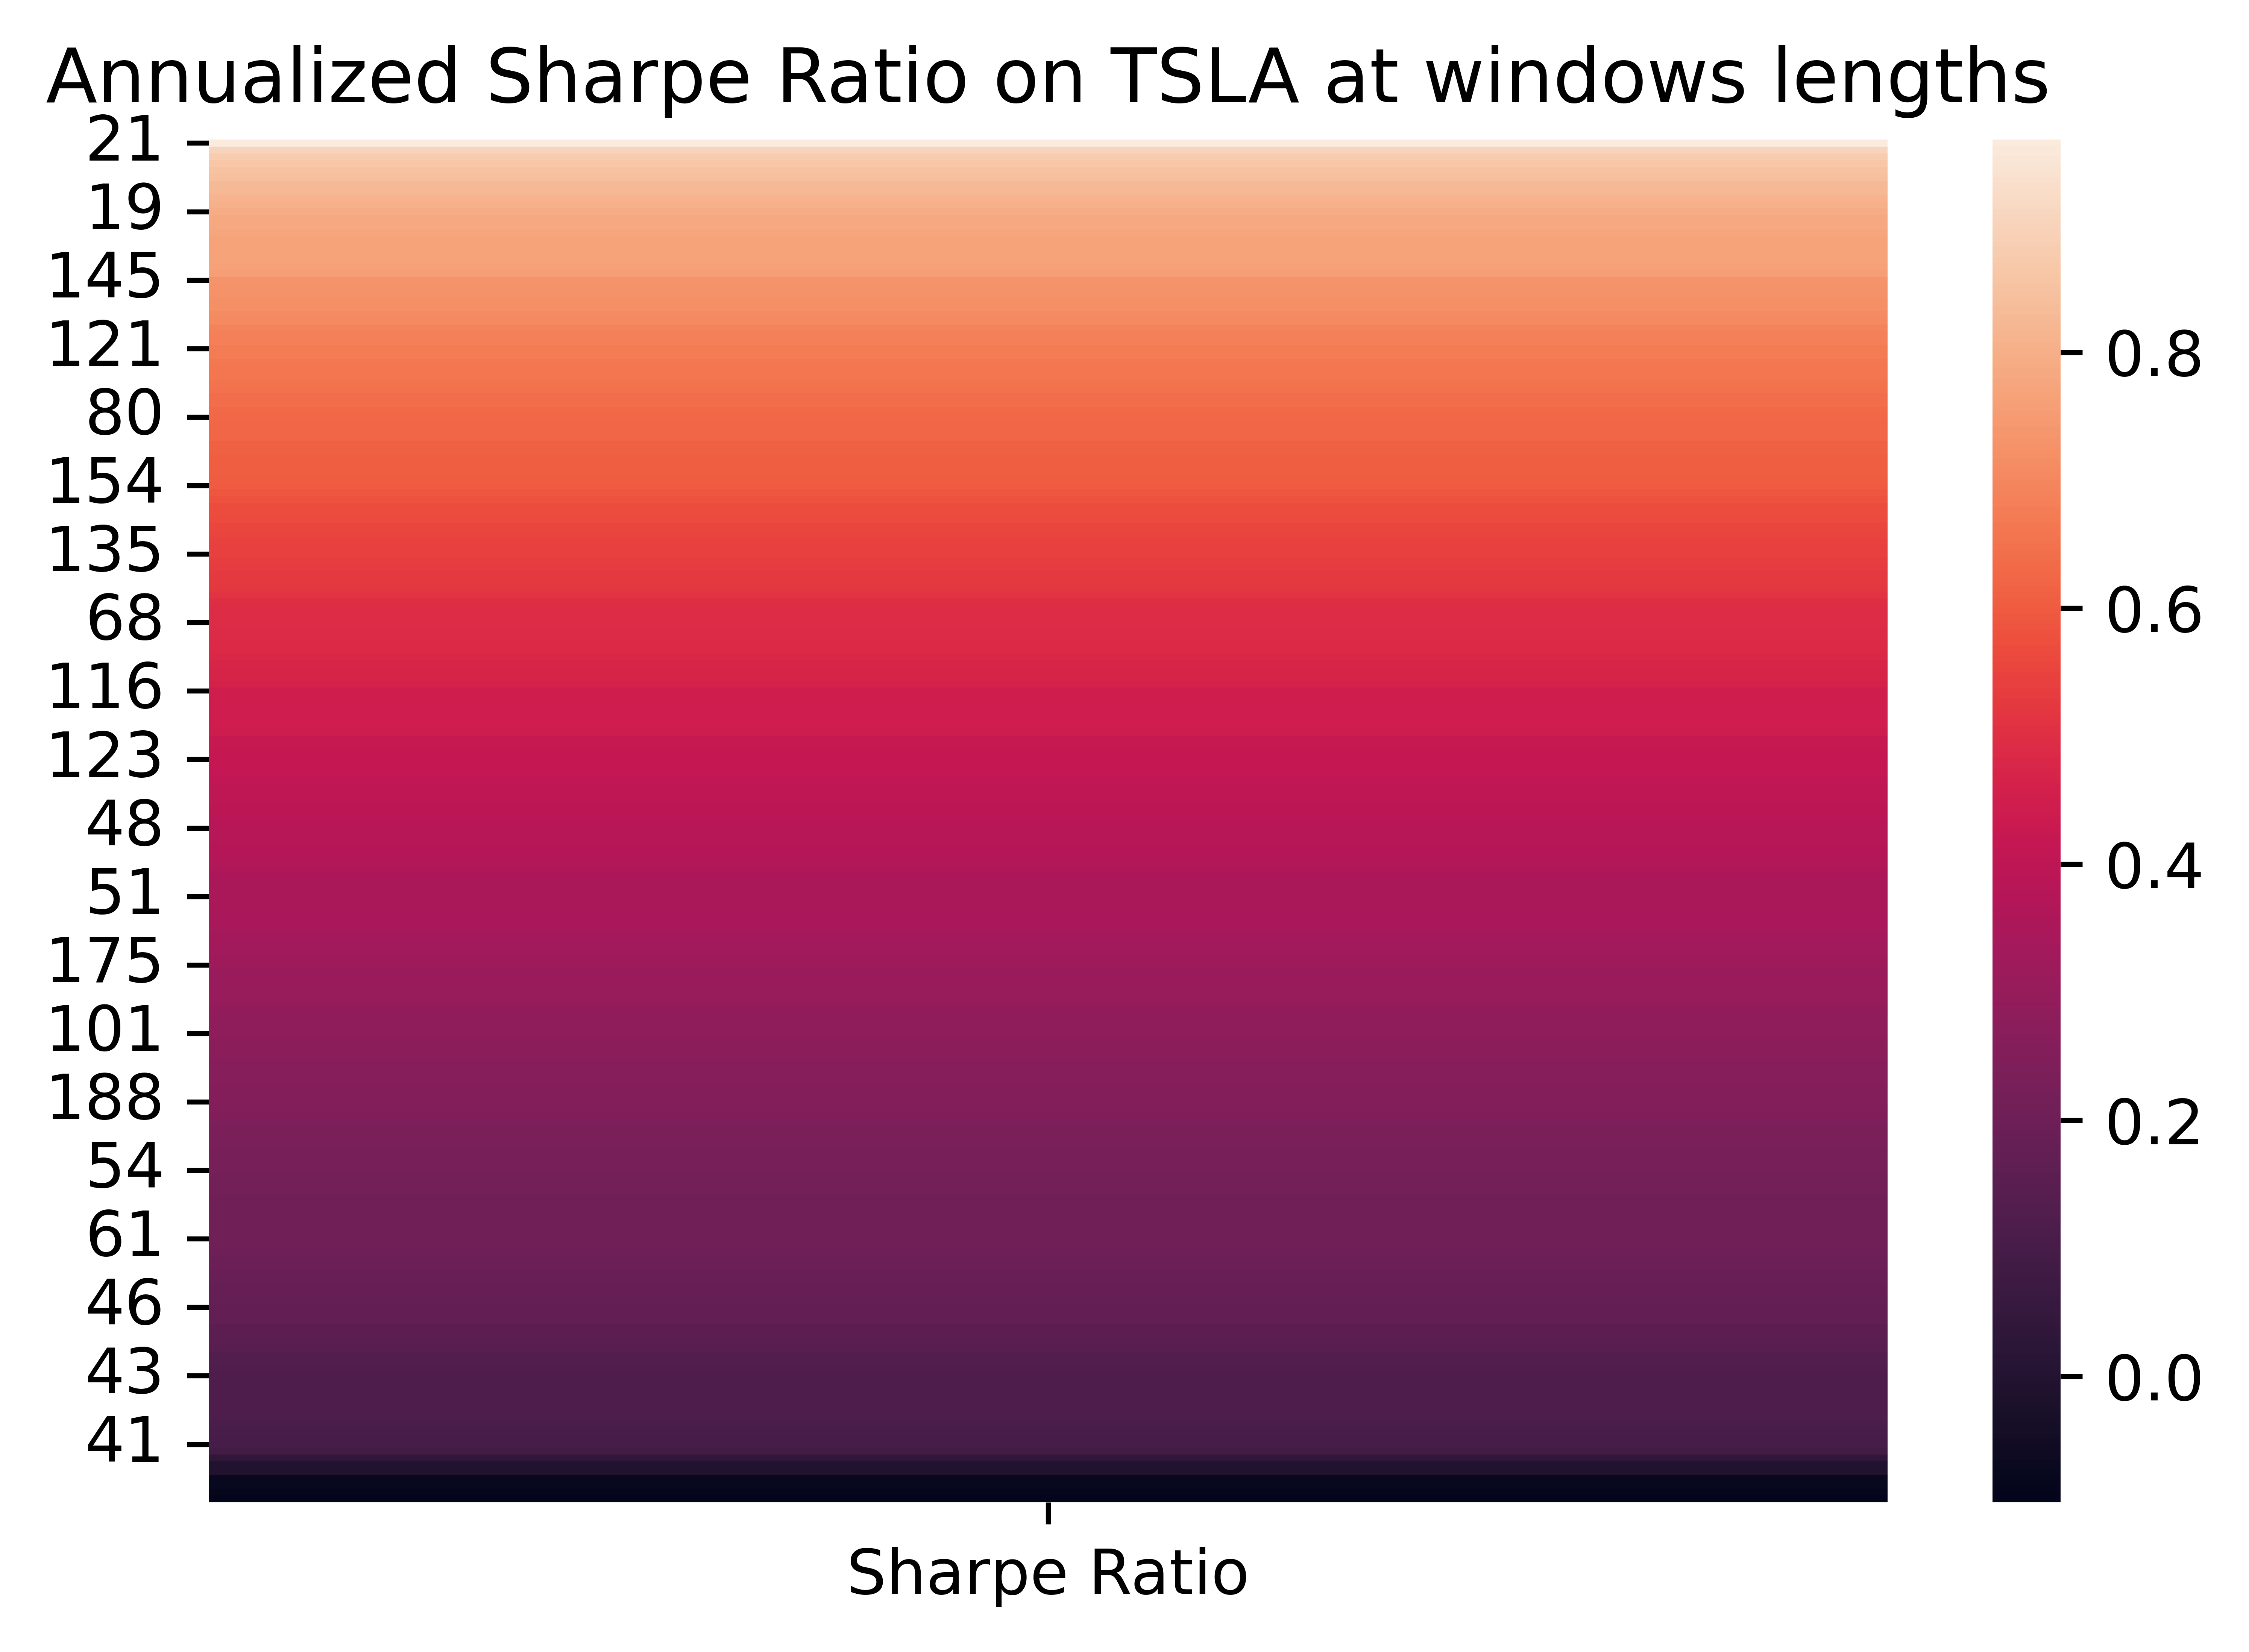

Top 10 Sharpe Ratio 
Window        Sharpe Ratio
    21          0.97
   126          0.90
   125          0.88
    78          0.86
    77          0.85
    22          0.84
    18          0.83
    76          0.83
    72          0.81
   146          0.80
Bottom 10 Sharpe Ratio:
Window        Sharpe Ratio
   184          0.10
    41          0.10
   199          0.09
    93          0.04
    37         -0.00
    92         -0.00
    57         -0.07
    58         -0.08
    56         -0.08
    44         -0.10


In [169]:
engine.drawHeatMap(200)

Return for strategy (window = 1): 0.68%
Return for strategy (window = 3): 246.14%


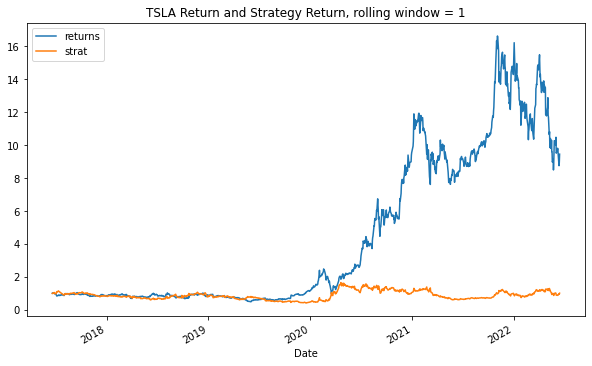

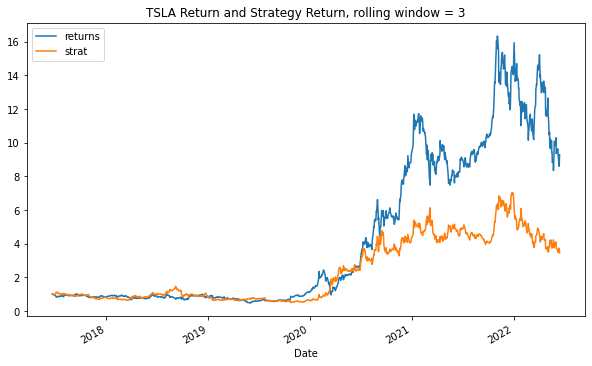

In [170]:
# test a single rolling window, e.g 1 day, 3 day mean
engine.single_test(1)
engine.single_test(3)

Return for strategy (window = 1): 1.74%
Return for strategy (window = 11): 107.25%
Return for strategy (window = 21): 1374.38%
Return for strategy (window = 31): 786.60%
Return for strategy (window = 41): 32.92%
Return for strategy (window = 51): 173.08%
Return for strategy (window = 61): 83.78%
Return for strategy (window = 71): 581.21%
Return for strategy (window = 81): 373.34%
Return for strategy (window = 91): -4.30%


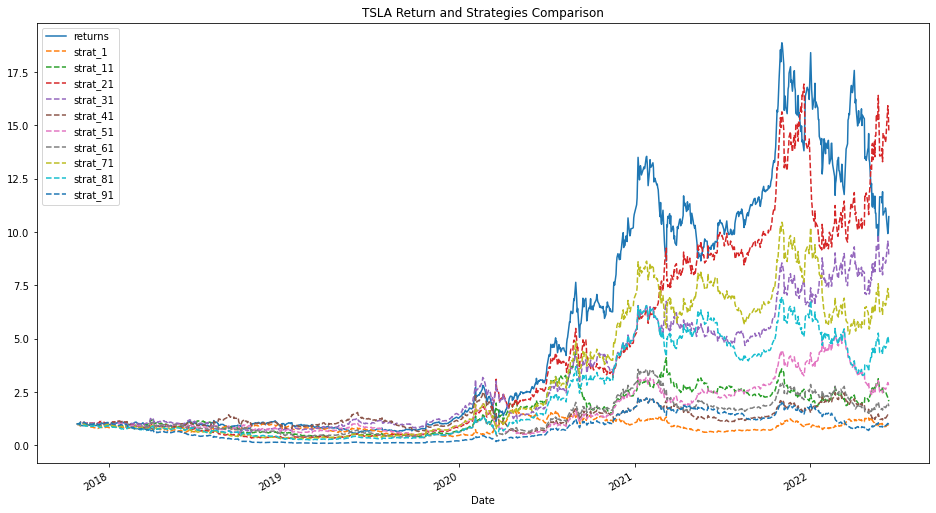

In [171]:
# test multiple rolling window at the same time. Input: min, max, step (as in python range function)
engine.multiple_test(1,100,10)